In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [29]:
# def application_train_test(num_rows = None, nan_as_category = False):
  df = pd.read_csv('/content/drive/My Drive/Database project/new_application_train.csv')
  print("Train samples: {}".format(df.shape))
  df = df.drop(['CODE_GENDER'], axis=1)
# Categorical features with Binary encode (0 or 1; two categories)
  for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
      df[bin_feature], uniques = pd.factorize(df[bin_feature])
# Categorical features with One-Hot encode
  df, cat_cols = one_hot_encoder(df, nan_as_category=False)

  # # NaN values for DAYS_EMPLOYED: 365.243 -> nan
  # df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
# # Some simple new features (percentages)
  df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
  df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
  df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
  df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
  df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
  print("Train samples: {}".format(df.shape))
    # gc.collect()
  # return df

Train samples: (307511, 127)
Train samples: (307511, 218)


In [30]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
  # Divide in training/validation and test data  
  # df = pd.read_csv('/content/drive/My Drive/Home Credit Risk/application_train.csv') ##remove this
  # num_folds=10
  df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
  df_new = df[df['TARGET'].notnull()]
  m = pd.DataFrame(np.random.randn(307509, 2))
  msk = np.random.rand(len(m)) < 0.8
  train_df = df_new[msk]
  test_df = df_new[~msk]
  print("Starting Logistic Regression. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

  oof_preds = np.zeros(train_df.shape[0])
  sub_preds = np.zeros(test_df.shape[0])
  y_preds = np.zeros(test_df.shape[0])
  feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

  # Logistic
  clf = LogisticRegression(class_weight = 'balanced')

  clf.fit(train_df[feats], train_df['TARGET'])

  # oof_preds[valid_idx] = clf.predict_proba(valid_x)
  sub_preds = clf.predict_proba(test_df[feats])
  y_preds = clf.predict(test_df[feats])

Starting Logistic Regression. Train shape: (245821, 218), test shape: (61688, 218)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [36]:
test_df_submission.shape

(61688, 220)

In [0]:
test_df_submission = test_df.copy()
test_df_submission['ORIG_TARGET'] = test_df_submission['TARGET']
test_df_submission['TARGET'] = y_preds
test_df_submission['SUB_PREDICTION'] = 1
test_df_submission['SUB_PREDICTION'] = sub_preds
test_df_submission[['SK_ID_CURR', 'ORIG_TARGET', 'TARGET', 'SUB_PREDICTION']].to_csv('submission_kernel05.csv', index= False)

In [32]:
print('Full training score %.6f' % clf.score(train_df[feats], train_df['TARGET']))
print('Full testing score %.6f' % clf.score(test_df[feats], test_df['TARGET']))

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from inspect import signature

test_df_submission = test_df.copy()
test_df_submission['ORIG_TARGET'] = test_df_submission['TARGET']
test_df_submission['TARGET'] = y_preds
test_df_submission['SUB_PREDICTION'] = 1
test_df_submission['SUB_PREDICTION'] = sub_preds
test_df_submission[['SK_ID_CURR', 'ORIG_TARGET', 'TARGET', 'SUB_PREDICTION']].to_csv('submission_kernel05.csv', index= False)

Full training score 0.591105
Full testing score 0.591963


Average precision-recall score: 0.12


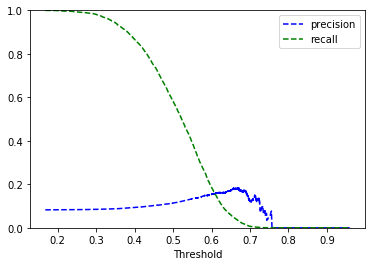

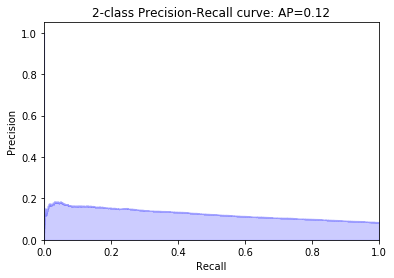

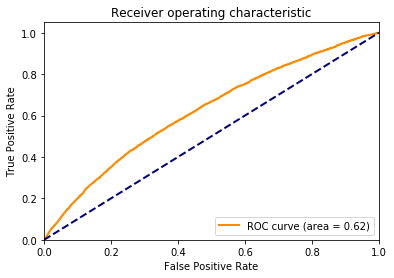

Accuracy score: 0.59


In [37]:
average_precision = average_precision_score(test_df_submission['ORIG_TARGET'], sub_preds[:, 1])
print ('Average precision-recall score: {0:0.2f}'.format(average_precision))

# Plot Precision Recall vs Threshold curve
prec, rec, tre = precision_recall_curve(test_df_submission['ORIG_TARGET'], sub_preds[:, 1])
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
  plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
  plt.xlabel('Threshold')
  plt.legend(loc='best')
  plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

# Plot Precision Recall curve
step_kwargs = ({'step': 'post'}
              if 'step' in signature(plt.fill_between).parameters
              else {})
plt.step(rec, prec, color='b', alpha=0.2,
        where='post')
plt.fill_between(rec, prec, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_df_submission['ORIG_TARGET'], sub_preds[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Print accuracy score
y_preds = np.array(y_preds, dtype=np.int64)
y_true = pd.Series(test_df_submission['ORIG_TARGET']).values
acc_score = accuracy_score(y_true, y_preds)
print ('Accuracy score: {0:0.2f}'.format(acc_score))

In [42]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_df_submission['ORIG_TARGET'], y_preds))

[[33560 23042]
 [ 2129  2957]]
